In [1]:
import sys

from sklearn.decomposition import PCA

from k_tuner import KTuner
from metrics import RankingMetricsEvaluator, TestMetricsCalculator

sys.path.append('./library')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

import pickle

pd.options.mode.chained_assignment = None  # Disable the warning

import numpy as np
from rating import get_explicit_rating, split_matrix_csr, sanity_check_explicit_split, sanity_check_explicit_matrix

In [5]:
PATH = '../../eda/dataset_samples/df_yelp_review_open_health_10.parquet'

In [6]:
review_df = pd.read_parquet(PATH)
review_df

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year,review_length
0,A8JR77dMCrnymyMhPQE7Qw,tL2pS5UOmN6aAOi3Z-qFGg,kEC675O6YwRH30ImVxBCCA,4,2017-02-16,I'm new to the area and stopped in here a few ...,0,0,0,2017,96
1,6Gd8tlhutYDMifKEzCvHyw,tL2pS5UOmN6aAOi3Z-qFGg,07F0eE_JHkH4Op0vpR_v4A,2,2013-05-09,I lived in this neighborhood a number of years...,2,0,0,2013,104
2,ZDMj4LnkO26QtM-CDtV94w,tL2pS5UOmN6aAOi3Z-qFGg,m-_IOYAreUyy_uyK9U3niQ,5,2013-02-03,It's been a few years since I've hiked this tr...,3,1,1,2013,109
3,8yfmu2iAagShVXJUGVTELw,tL2pS5UOmN6aAOi3Z-qFGg,6zry3kyGHiplbQ4rdqxbaQ,4,2013-07-17,This is a challenging hike to one of the most ...,0,0,0,2013,46
4,HaIBF7a1HjFT-gOIlmSIdQ,tL2pS5UOmN6aAOi3Z-qFGg,b3z314J6wktaNVblxumiug,5,2014-07-18,This is one if my favorite trails in the Redro...,0,0,0,2014,42
...,...,...,...,...,...,...,...,...,...,...,...
31736,JZJts6Y7gG5Uog6zyiXo5w,IqIpCfg0qDhIkaUJGKzlyw,KlLCJN_KUP9xFQBJYrhgVg,5,2012-10-21,pretty hospital great staff!! I had a great p...,0,0,0,2012,31
31737,Lp4ZHWDrDoXM2HHkZTh90g,IqIpCfg0qDhIkaUJGKzlyw,U-9uOCu4tG4idBAnMPmZTw,4,2012-08-15,I like this place because I live by it!! Mini ...,1,1,1,2012,57
31738,oQP82Wz-gIlV2qG53EacGA,IqIpCfg0qDhIkaUJGKzlyw,wghDrzcZ0VloAtaIZ7GEBg,4,2013-06-07,There's parking thank goodness. I hiked here f...,2,0,0,2013,41
31739,KZEEqRkPNDVTCZCBb93iYA,IqIpCfg0qDhIkaUJGKzlyw,4xkjmpgUNJdwQo8FKIYp6Q,3,2012-07-28,I bought a groupon yay at $13 and it was so wo...,5,1,1,2012,166


In [7]:
REMAINED_FEATURES = ['review_id', 'user_id', 'business_id', 'stars', 'date']

filtered_review_df = review_df[REMAINED_FEATURES]
filtered_review_df.set_index('review_id', inplace=True)
filtered_review_df

,user_id,business_id,stars,date
review_id,,,,
A8JR77dMCrnymyMhPQE7Qw,tL2pS5UOmN6aAOi3Z-qFGg,kEC675O6YwRH30ImVxBCCA,4,2017-02-16
6Gd8tlhutYDMifKEzCvHyw,tL2pS5UOmN6aAOi3Z-qFGg,07F0eE_JHkH4Op0vpR_v4A,2,2013-05-09
ZDMj4LnkO26QtM-CDtV94w,tL2pS5UOmN6aAOi3Z-qFGg,m-_IOYAreUyy_uyK9U3niQ,5,2013-02-03
8yfmu2iAagShVXJUGVTELw,tL2pS5UOmN6aAOi3Z-qFGg,6zry3kyGHiplbQ4rdqxbaQ,4,2013-07-17
HaIBF7a1HjFT-gOIlmSIdQ,tL2pS5UOmN6aAOi3Z-qFGg,b3z314J6wktaNVblxumiug,5,2014-07-18
...,...,...,...,...
JZJts6Y7gG5Uog6zyiXo5w,IqIpCfg0qDhIkaUJGKzlyw,KlLCJN_KUP9xFQBJYrhgVg,5,2012-10-21
Lp4ZHWDrDoXM2HHkZTh90g,IqIpCfg0qDhIkaUJGKzlyw,U-9uOCu4tG4idBAnMPmZTw,4,2012-08-15
oQP82Wz-gIlV2qG53EacGA,IqIpCfg0qDhIkaUJGKzlyw,wghDrzcZ0VloAtaIZ7GEBg,4,2013-06-07


In [8]:
filtered_review_df["date"] = pd.to_datetime(filtered_review_df["date"]).astype(np.int64) // 10 ** 9
filtered_review_df

,user_id,business_id,stars,date
review_id,,,,
A8JR77dMCrnymyMhPQE7Qw,tL2pS5UOmN6aAOi3Z-qFGg,kEC675O6YwRH30ImVxBCCA,4,1487203200
6Gd8tlhutYDMifKEzCvHyw,tL2pS5UOmN6aAOi3Z-qFGg,07F0eE_JHkH4Op0vpR_v4A,2,1368057600
ZDMj4LnkO26QtM-CDtV94w,tL2pS5UOmN6aAOi3Z-qFGg,m-_IOYAreUyy_uyK9U3niQ,5,1359849600
8yfmu2iAagShVXJUGVTELw,tL2pS5UOmN6aAOi3Z-qFGg,6zry3kyGHiplbQ4rdqxbaQ,4,1374019200
HaIBF7a1HjFT-gOIlmSIdQ,tL2pS5UOmN6aAOi3Z-qFGg,b3z314J6wktaNVblxumiug,5,1405641600
...,...,...,...,...
JZJts6Y7gG5Uog6zyiXo5w,IqIpCfg0qDhIkaUJGKzlyw,KlLCJN_KUP9xFQBJYrhgVg,5,1350777600
Lp4ZHWDrDoXM2HHkZTh90g,IqIpCfg0qDhIkaUJGKzlyw,U-9uOCu4tG4idBAnMPmZTw,4,1344988800
oQP82Wz-gIlV2qG53EacGA,IqIpCfg0qDhIkaUJGKzlyw,wghDrzcZ0VloAtaIZ7GEBg,4,1370563200


In [9]:
explicit_ratings, last_dates, user_mapping, item_mapping = get_explicit_rating(filtered_review_df, "user_id",
                                                                               "business_id", "stars", "date")

explicit_ratings.toarray(), last_dates.toarray()

(array([[4., 2., 5., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 4., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1487203200, 1368057600, 1359849600, ...,          0,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0],
        ...,
        [         0,          0,          0, ...,          0,          0,
                  0],
        [         0,          0,          0, ..., 1486771200,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0]]))

In [10]:
sanity_check_explicit_matrix(explicit_ratings=explicit_ratings, last_dates=last_dates, review_df=review_df,
                             user_field="user_id", item_field="business_id")

,Source,Calculated metrics,Value
0,Explicit ratings matrix,Non-zero entries,31740
1,Last dates matrix,Non-zero entries,31740
2,Filtered review DataFrame,"Unique (user_id, business_id) pairs",31740


In [11]:
DIVISIONS = [0.1, 0.2, 0.7]

In [12]:
test_matrix, validation_matrix, train_matrix = split_matrix_csr(explicit_ratings, last_dates, DIVISIONS)
train_matrix.toarray(), validation_matrix.toarray(), test_matrix.toarray()

(array([[0., 2., 5., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 4., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[4., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [13]:
sanity_check_explicit_split(train_matrix=train_matrix, validation_matrix=validation_matrix, test_matrix=test_matrix,
                            explicit_matrix=explicit_ratings)

,Split,Number of interactions,Part of factual interactions
0,Train,22548,71.04%
1,Validation,6136,19.33%
2,Test,3056,9.63%
3,Explicit total,31740,100.0%
4,Factual total,31740,100%


# User features preparation

In [14]:
USER_DATASET_PATH = '../../eda/dataset_samples/yelp_user_parquet.parquet'

In [15]:
user_features = pd.read_parquet(USER_DATASET_PATH)
user_features['elite']

0           
1           
2           
3           
4           
          ..
1326095     
1326096     
1326097     
1326098     
1326099     
Name: elite, Length: 1326100, dtype: object

In [16]:
USER_COLUMNS_TO_DROP = ['name', 'yelping_since', 'friends', 'join_year', 'account_age', 'total_compliments', 'elite']
dropped_user_features = user_features.drop(USER_COLUMNS_TO_DROP, axis=1)
dropped_user_features

,user_id,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_years,gender
0,JJ-aSuM4pCFPdkfoZ34q0Q,10,0,0,0,0,3.70,0,0,0,...,0,0,0,0,0,0,0,79,0,male
1,uUzsFQn_6cXDh6rPNGbIFA,1,0,0,0,0,2.00,0,0,0,...,0,0,0,0,0,0,0,0,0,unknown
2,mBneaEEH5EMyxaVyqS-72A,6,0,0,0,0,4.67,0,0,0,...,0,0,0,0,0,0,0,0,0,male
3,W5mJGs-dcDWRGEhAzUYtoA,3,0,0,0,0,4.67,0,0,0,...,0,0,0,0,0,0,0,0,0,female
4,4E8--zUZO1Rr1IBK4_83fg,11,4,0,0,0,3.45,0,0,0,...,0,0,0,0,0,1,0,0,0,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326095,LODBIwiAcKxRi7Wz-sFsKw,1,0,0,0,0,5.00,0,0,0,...,0,0,0,0,0,0,0,0,0,unknown
1326096,JpY2ozlb30z_AZCq2YX34g,1,2,0,0,0,5.00,0,0,0,...,0,0,0,0,0,0,1,0,0,male
1326097,AU9aZSA1rAjNE5cFcZTVMA,12,0,0,0,0,1.85,0,0,0,...,0,0,0,0,0,0,0,0,0,unknown
1326098,s1BZ7-rpqb3xRKcxvArXsQ,33,5,0,0,0,3.97,0,0,0,...,0,0,1,0,0,0,0,0,0,female


In [17]:
dropped_user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326100 entries, 0 to 1326099
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             1326100 non-null  object 
 1   review_count        1326100 non-null  int64  
 2   useful              1326100 non-null  int64  
 3   funny               1326100 non-null  int64  
 4   cool                1326100 non-null  int64  
 5   fans                1326100 non-null  int64  
 6   average_stars       1326100 non-null  float64
 7   compliment_hot      1326100 non-null  int64  
 8   compliment_more     1326100 non-null  int64  
 9   compliment_profile  1326100 non-null  int64  
 10  compliment_cute     1326100 non-null  int64  
 11  compliment_list     1326100 non-null  int64  
 12  compliment_note     1326100 non-null  int64  
 13  compliment_plain    1326100 non-null  int64  
 14  compliment_cool     1326100 non-null  int64  
 15  compliment_funn

In [18]:
indexed_user_df = dropped_user_features[dropped_user_features['user_id'].isin(user_mapping['id_to_idx'])]
indexed_user_df['user_id'] = indexed_user_df['user_id'].map(user_mapping['id_to_idx'])

indexed_user_df = indexed_user_df.set_index('user_id').sort_index()
indexed_user_df

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_years,gender
user_id,,,,,,,,,,,,,,,,,,,,
0,646,147,75,48,19,3.63,0,4,1,0,1,7,14,5,5,6,0,92,1,male
1,143,2,1,1,4,4.04,3,0,0,0,0,2,0,7,7,3,0,206,2,female
2,314,59,18,19,28,3.72,34,4,3,1,6,22,31,38,38,15,3,172,5,female
3,204,90,52,39,8,4.13,6,1,0,3,0,4,13,6,6,6,11,124,2,female
4,279,16,13,2,8,4.00,5,1,0,1,0,6,6,10,10,5,1,330,6,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,270,5,1,0,2,4.27,0,0,0,0,0,1,0,2,2,1,1,195,3,male
1692,355,1653,154,1303,30,3.71,47,4,4,1,1,49,98,84,84,45,8,122,3,female
1693,30,0,0,0,1,3.65,0,0,0,0,0,1,0,1,1,0,0,18,0,female


In [19]:
gender_dummies = pd.get_dummies(indexed_user_df['gender'], prefix='gender').astype(int)

final_user_df = pd.concat([indexed_user_df.drop(columns='gender'), gender_dummies], axis=1)
final_user_df = final_user_df.drop(['gender_unknown'], axis=1)

final_user_df

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_years,gender_female,gender_male
user_id,,,,,,,,,,,,,,,,,,,,,
0,646,147,75,48,19,3.63,0,4,1,0,...,7,14,5,5,6,0,92,1,0,1
1,143,2,1,1,4,4.04,3,0,0,0,...,2,0,7,7,3,0,206,2,1,0
2,314,59,18,19,28,3.72,34,4,3,1,...,22,31,38,38,15,3,172,5,1,0
3,204,90,52,39,8,4.13,6,1,0,3,...,4,13,6,6,6,11,124,2,1,0
4,279,16,13,2,8,4.00,5,1,0,1,...,6,6,10,10,5,1,330,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,270,5,1,0,2,4.27,0,0,0,0,...,1,0,2,2,1,1,195,3,0,1
1692,355,1653,154,1303,30,3.71,47,4,4,1,...,49,98,84,84,45,8,122,3,1,0
1693,30,0,0,0,1,3.65,0,0,0,0,...,1,0,1,1,0,0,18,0,1,0


In [20]:
final_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1696 entries, 0 to 1695
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_count        1696 non-null   int64  
 1   useful              1696 non-null   int64  
 2   funny               1696 non-null   int64  
 3   cool                1696 non-null   int64  
 4   fans                1696 non-null   int64  
 5   average_stars       1696 non-null   float64
 6   compliment_hot      1696 non-null   int64  
 7   compliment_more     1696 non-null   int64  
 8   compliment_profile  1696 non-null   int64  
 9   compliment_cute     1696 non-null   int64  
 10  compliment_list     1696 non-null   int64  
 11  compliment_note     1696 non-null   int64  
 12  compliment_plain    1696 non-null   int64  
 13  compliment_cool     1696 non-null   int64  
 14  compliment_funny    1696 non-null   int64  
 15  compliment_writer   1696 non-null   int64  
 16  compliment_

# Item features preparation

In [21]:
BUSINESS_DATASET_PATH = '../../eda/dataset_samples/yelp_business_parquet.parquet'

In [22]:
business_features = pd.read_parquet(BUSINESS_DATASET_PATH)
business_features

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",None,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",None,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",None,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",None,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",None,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,"""Whitby Toyota""",None,"""1025 Dundas Street W""",Whitby,ON,L1P 1Z1,43.873460,-78.968033,4.0,4,1,Car Dealers;Automotive
174563,gRGalHVu6BcaUDIAGVW_xQ,"""Village Auto Body""",None,"""3957 Brecksville Rd""",Richfield,OH,44286,41.243385,-81.636212,5.0,3,1,Body Shops;Automotive
174564,XXvZBIHoJBU5d6-a-oyMWQ,"""AAM""",None,"""1600 W Broadway Rd, Ste 200""",Tempe,AZ,85282,33.407914,-111.965098,1.5,19,1,Home Services;Property Management;Real Estate
174565,lNpPGgM96nPIYM1shxciHg,"""Bronze Beauty Spray Tanning""",None,"""300 Camp Horne Rd, Ste 250""",Pittsburgh,PA,15202,40.517724,-80.091466,5.0,14,1,Spray Tanning;Tanning;Beauty & Spas


In [23]:
dropped_business_features = business_features.drop(columns=['name', 'address', 'postal_code', 'is_open', 'neighborhood'])
dropped_business_features

,business_id,city,state,latitude,longitude,stars,review_count,categories
0,FYWN1wneV18bWNgQjJ2GNg,Ahwatukee,AZ,33.330690,-111.978599,4.0,22,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,McMurray,PA,40.291685,-80.104900,3.0,11,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Phoenix,AZ,33.524903,-112.115310,1.5,18,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,Tempe,AZ,33.383147,-111.964725,3.0,9,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,Cuyahoga Falls,OH,41.119535,-81.475690,3.5,116,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,Whitby,ON,43.873460,-78.968033,4.0,4,Car Dealers;Automotive
174563,gRGalHVu6BcaUDIAGVW_xQ,Richfield,OH,41.243385,-81.636212,5.0,3,Body Shops;Automotive
174564,XXvZBIHoJBU5d6-a-oyMWQ,Tempe,AZ,33.407914,-111.965098,1.5,19,Home Services;Property Management;Real Estate
174565,lNpPGgM96nPIYM1shxciHg,Pittsburgh,PA,40.517724,-80.091466,5.0,14,Spray Tanning;Tanning;Beauty & Spas


In [24]:
dropped_business_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   174567 non-null  object 
 1   city          174566 non-null  object 
 2   state         174566 non-null  object 
 3   latitude      174566 non-null  float64
 4   longitude     174566 non-null  float64
 5   stars         174567 non-null  float64
 6   review_count  174567 non-null  int64  
 7   categories    174567 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 10.7+ MB


In [25]:
categories = dropped_business_features['categories'].str.get_dummies(sep=';')
categories_business_df = pd.concat([dropped_business_features.drop(columns='categories'), categories], axis=1)

categories_business_df

,business_id,city,state,latitude,longitude,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,...,Wine Tours,Wineries,Wok,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
0,FYWN1wneV18bWNgQjJ2GNg,Ahwatukee,AZ,33.330690,-111.978599,4.0,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,He-G7vWjzVUysIKrfNbPUQ,McMurray,PA,40.291685,-80.104900,3.0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KQPW8lFf1y5BT2MxiSZ3QA,Phoenix,AZ,33.524903,-112.115310,1.5,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8DShNS-LuFqpEWIp0HxijA,Tempe,AZ,33.383147,-111.964725,3.0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PfOCPjBrlQAnz__NXj9h_w,Cuyahoga Falls,OH,41.119535,-81.475690,3.5,116,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,Whitby,ON,43.873460,-78.968033,4.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174563,gRGalHVu6BcaUDIAGVW_xQ,Richfield,OH,41.243385,-81.636212,5.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174564,XXvZBIHoJBU5d6-a-oyMWQ,Tempe,AZ,33.407914,-111.965098,1.5,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174565,lNpPGgM96nPIYM1shxciHg,Pittsburgh,PA,40.517724,-80.091466,5.0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
city_dummies = pd.get_dummies(categories_business_df['city'], prefix='city')
state_dummies = pd.get_dummies(categories_business_df['state'], prefix='state')

city_business_df = pd.concat([
    categories_business_df.drop(columns=['city', 'state']),
    city_dummies,
    state_dummies
], axis=1)
city_business_df

,business_id,latitude,longitude,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,...,state_TAM,state_VA,state_VS,state_VT,state_WA,state_WHT,state_WI,state_WLN,state_XGL,state_ZET
0,FYWN1wneV18bWNgQjJ2GNg,33.330690,-111.978599,4.0,22,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,He-G7vWjzVUysIKrfNbPUQ,40.291685,-80.104900,3.0,11,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,KQPW8lFf1y5BT2MxiSZ3QA,33.524903,-112.115310,1.5,18,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,8DShNS-LuFqpEWIp0HxijA,33.383147,-111.964725,3.0,9,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,PfOCPjBrlQAnz__NXj9h_w,41.119535,-81.475690,3.5,116,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174562,ALV5R8NkZ1KGOZeuZl3u0A,43.873460,-78.968033,4.0,4,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
174563,gRGalHVu6BcaUDIAGVW_xQ,41.243385,-81.636212,5.0,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
174564,XXvZBIHoJBU5d6-a-oyMWQ,33.407914,-111.965098,1.5,19,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
174565,lNpPGgM96nPIYM1shxciHg,40.517724,-80.091466,5.0,14,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [27]:
final_business_df = city_business_df[city_business_df['business_id'].isin(item_mapping['id_to_idx'])]
final_business_df['business_id'] = city_business_df['business_id'].map(item_mapping['id_to_idx'])

final_business_df = final_business_df.set_index('business_id').sort_index()
final_business_df

,latitude,longitude,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,...,state_TAM,state_VA,state_VS,state_VT,state_WA,state_WHT,state_WI,state_WLN,state_XGL,state_ZET
business_id,,,,,,,,,,,,,,,,,,,,,
0.0,36.093774,-115.294025,2.5,145,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1.0,36.102341,-115.110111,3.0,15,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2.0,35.946117,-115.081075,5.0,22,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3.0,36.111011,-115.449328,4.5,44,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4.0,36.081491,-115.447989,4.5,21,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144.0,43.778096,-79.246548,3.5,13,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
10145.0,43.519586,-79.704156,5.0,5,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
10146.0,36.208196,-115.254583,4.0,9,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [28]:
def calculate_explained_variance(pca):
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 3), explained_variance * 100, tick_label=['PC1', 'PC2'])
    plt.ylabel('Explained variance (%)')
    plt.xlabel('Main components')
    plt.title('Explained variance')
    plt.show()

In [34]:
result_features_pca = PCA(n_components=2)
final_business_pca_df = pd.DataFrame(result_features_pca.fit_transform(final_business_df))
final_business_pca_df

,0,1
0,120.776304,-6.307879
1,-8.923262,-15.100776
2,-1.941306,-14.614147
3,20.030643,-13.432890
4,-2.914104,-15.025138
...,...,...
10144,-13.449236,21.335317
10145,-21.396127,20.284620
10146,-14.900191,-15.641295
10147,3.683439,19.931034


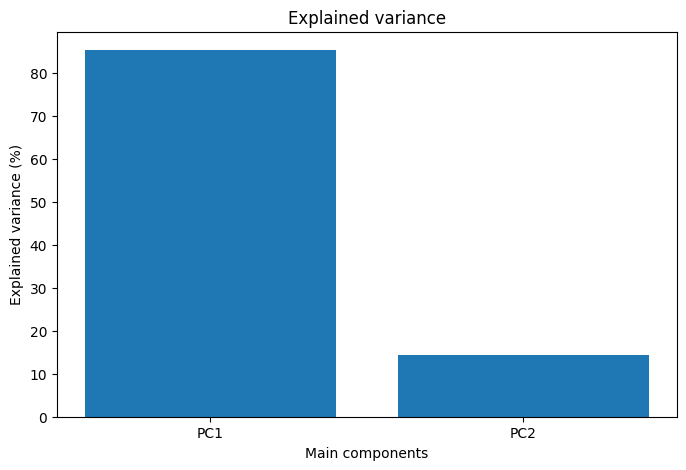

In [35]:
calculate_explained_variance(result_features_pca)

# Content-based ItemKnn


In [36]:
K_RANGE = [i for i in range(10, 301, 10)]

INFO:root:Evaluating k=10...
INFO:root:F1 score @ top-10 for k=10: 0.0017
INFO:root:Evaluating k=20...
INFO:root:F1 score @ top-10 for k=20: 0.0000
INFO:root:Evaluating k=30...
INFO:root:F1 score @ top-10 for k=30: 0.0000
INFO:root:Evaluating k=40...
INFO:root:F1 score @ top-10 for k=40: 0.0000
INFO:root:Evaluating k=50...
INFO:root:F1 score @ top-10 for k=50: 0.0000
INFO:root:Evaluating k=60...
INFO:root:F1 score @ top-10 for k=60: 0.0000
INFO:root:Evaluating k=70...
INFO:root:F1 score @ top-10 for k=70: 0.0000
INFO:root:Evaluating k=80...
INFO:root:F1 score @ top-10 for k=80: 0.0000
INFO:root:Evaluating k=90...
INFO:root:F1 score @ top-10 for k=90: 0.0000
INFO:root:Evaluating k=100...
INFO:root:F1 score @ top-10 for k=100: 0.0000
INFO:root:Evaluating k=110...
INFO:root:F1 score @ top-10 for k=110: 0.0000
INFO:root:Evaluating k=120...
INFO:root:F1 score @ top-10 for k=120: 0.0000
INFO:root:Evaluating k=130...
INFO:root:F1 score @ top-10 for k=130: 0.0000
INFO:root:Evaluating k=140...


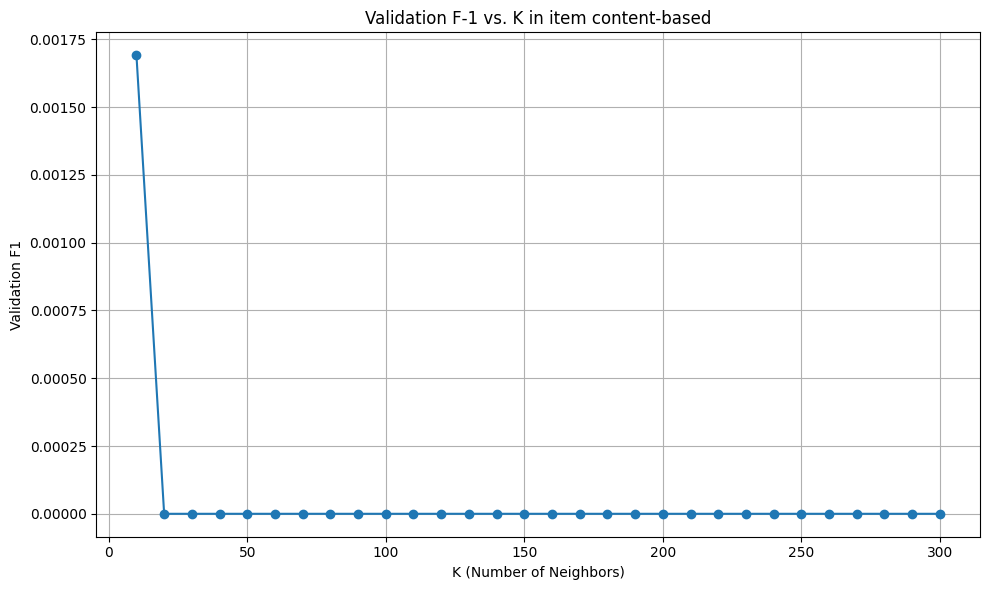

(<item_knn_content.ItemKnnContent at 0x36c8c4ec0>, 10)

In [37]:
business_tuner = KTuner(val_matrix=validation_matrix, similarity_features=final_business_pca_df,
                    item_mapping=item_mapping, user_mapping=user_mapping, k_values=K_RANGE, type='item')

best_business_model, best_business_k, best_business_params = business_tuner.tune()
best_business_model, best_business_k

In [ ]:
with open("../../models/content_based_item_knn.pkl", "wb") as f:
    pickle.dump(best_business_model, f)

In [ ]:
business_accuracy_test = RankingMetricsEvaluator(matrix=test_matrix, model=best_business_model, user_mapping=user_mapping,item_mapping=item_mapping)

business_accuracy_test.summary()

In [ ]:
business_test = TestMetricsCalculator(test_matrix=test_matrix, model=best_business_model, user_mapping=user_mapping,item_mapping=item_mapping, model_type='ranking')

In [ ]:
business_test.generate_metrics_summary_df()

# Content-based UserKnn

INFO:root:Evaluating k=10...
INFO:root:F1 score @ top-10 for k=10: 0.0018
INFO:root:Evaluating k=20...
INFO:root:F1 score @ top-10 for k=20: 0.0022
INFO:root:Evaluating k=30...
INFO:root:F1 score @ top-10 for k=30: 0.0033
INFO:root:Evaluating k=40...
INFO:root:F1 score @ top-10 for k=40: 0.0038
INFO:root:Evaluating k=50...
INFO:root:F1 score @ top-10 for k=50: 0.0042
INFO:root:Evaluating k=60...
INFO:root:F1 score @ top-10 for k=60: 0.0046
INFO:root:Evaluating k=70...
INFO:root:F1 score @ top-10 for k=70: 0.0048
INFO:root:Evaluating k=80...
INFO:root:F1 score @ top-10 for k=80: 0.0054
INFO:root:Evaluating k=90...
INFO:root:F1 score @ top-10 for k=90: 0.0061
INFO:root:Evaluating k=100...
INFO:root:F1 score @ top-10 for k=100: 0.0070
INFO:root:Evaluating k=110...
INFO:root:F1 score @ top-10 for k=110: 0.0075
INFO:root:Evaluating k=120...
INFO:root:F1 score @ top-10 for k=120: 0.0071
INFO:root:Evaluating k=130...
INFO:root:F1 score @ top-10 for k=130: 0.0065
INFO:root:Evaluating k=140...


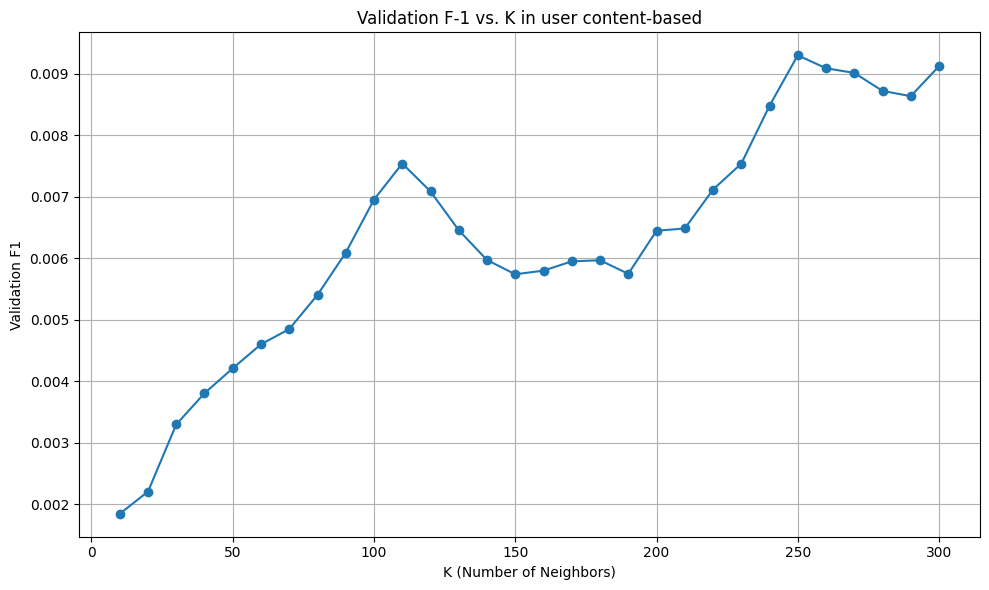

(250, 0.009297864447121756)

In [68]:
user_tuner = KTuner(val_matrix=validation_matrix, similarity_features=final_user_df,
                    item_mapping=item_mapping, user_mapping=user_mapping, k_values=K_RANGE, type='user')

best_user_model, best_user_k, best_user_params = user_tuner.tune()
best_user_k, best_user_params

In [71]:
with open("../../models/content_based_user_knn.pkl", "wb") as f:
    pickle.dump(best_user_model, f)

In [72]:
user_accuracy_test = RankingMetricsEvaluator(matrix=test_matrix, model=best_user_model, user_mapping=user_mapping,item_mapping=item_mapping)

user_accuracy_test.summary()

Precision    0.002948
Recall       0.017355
F1           0.004829
Accuracy     0.998843
dtype: float64

In [73]:
user_test = TestMetricsCalculator(test_matrix=test_matrix, model=best_user_model, user_mapping=user_mapping,item_mapping=item_mapping, model_type='ranking')

INFO:root:Create top-10 recommendations' list
INFO:root:User: 0 -- top 10 list -- [58, 1697, 569, 1515, 508, 1199, 2352, 1418, 873, 2194]
INFO:root:User: 1 -- top 10 list -- [68, 151, 55, 58, 940, 67, 31, 1065, 569, 1814]
INFO:root:User: 2 -- top 10 list -- [55, 151, 68, 1344, 58, 247, 242, 96, 243, 239]
INFO:root:User: 3 -- top 10 list -- [55, 68, 151, 247, 1326, 368, 314, 556, 239, 801]
INFO:root:User: 4 -- top 10 list -- [58, 68, 151, 55, 940, 67, 31, 96, 463, 569]
INFO:root:User: 5 -- top 10 list -- [55, 151, 68, 247, 314, 1344, 1216, 239, 368, 3009]
INFO:root:User: 6 -- top 10 list -- [68, 67, 55, 15, 320, 131, 236, 151, 556, 32]
INFO:root:User: 7 -- top 10 list -- [67, 68, 55, 320, 105, 940, 151, 32, 556, 3730]
INFO:root:User: 8 -- top 10 list -- [247, 58, 114, 30, 68, 96, 717, 508, 151, 4736]
INFO:root:User: 9 -- top 10 list -- [571, 67, 55, 10, 151, 446, 31, 75, 1002, 3709]
INFO:root:User: 10 -- top 10 list -- [68, 55, 151, 314, 499, 368, 1344, 2185, 1216, 801]
INFO:root:User: 

In [74]:
user_test.generate_metrics_summary_df()

,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,0.488000,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.012028,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.020101,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,20.293000,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.257000,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.328000,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.000000,"[0, 1]",Proportion of unexpected and relevant items in...
